# Evaluation of multi-cell experiments

The purpose of this notebook is to create plots for the multi-cell experiments were we analyze the optimal treatments for various values of lambda.

In [1]:
# Adapt path to allow imports from project
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
import seaborn as sns
from src.baseline.evaluate import build_combined_single_frame, build_combined_dual_frame, best_single_treatment, best_dual_treatment
from src.baseline.evaluate import best_single_treatment_by_dosage, best_dual_treatment_by_dosage
from src.search.evaluate_search import best_multi_search_result
from src.env.cell_lines import retrieve_lines

In [3]:
%pylab inline
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['ptm', 'Helvetica', 'Times New Roman']

Populating the interactive namespace from numpy and matplotlib


#### Configuration

In [4]:
# param for retrieval
LAMBDAS = np.arange(-7.0, -1.0 + 0.01, 0.25)
OBJ = "worst"
DOMAIN = "simplex"

In [5]:
# meta
PATH_EVAL = "./artifacts/evaluation/multi/"
PATH_DATA = "./artifacts/multi/"
TISSUE = "wmd"
# TISSUE = "intestine"
THRESHOLD = 8000
VERIFICATION = False

#### Prepare Data

In [6]:
# functions for data retrieval

def get_data_search():
    lambdas, proliferations, objectives, concentrations, treatments = [], [], [], [], []
    for la in LAMBDAS:
        # prepare prefix
        if la == 12345:
            lambd = 0
            prefix = OBJ + "_" + DOMAIN + "_" + "prolif" + "_cma_es" # create prefix here and then give it to function
        else: 
            prefix = OBJ + "_" + DOMAIN + "_" + str(la).replace(".", "_") + "_cma_es" # create prefix here and then give it to function
            lambd = 10 ** la
        treat, o_dos, o_pro, o_obj = best_multi_search_result(TISSUE, PATH_DATA, prefix, lambd=lambd, obj=OBJ, max_dosage=THRESHOLD, verification=VERIFICATION)
        lambdas.append(lambd)
        proliferations.append(o_pro)
        objectives.append(o_obj)
        concentrations.append(o_dos)
        treatments.append(treat)
        
        if len(proliferations) % 5 == 0:
            print("   ...%2d lambdas loaded..." % len(lambdas))
    return lambdas, proliferations, objectives, concentrations, treatments

def get_data_single(lambdas):
    comb_data = build_combined_single_frame(retrieve_lines(TISSUE))
    proliferations, objectives, concentrations = [], [], []
    for lambd in lambdas:
        treat, s_dos, s_pro, s_obj = best_single_treatment(retrieve_lines(TISSUE), lambd=lambd, obj=OBJ, max_dosage=THRESHOLD, verification=VERIFICATION, comb_data=comb_data)
        proliferations.append(s_pro)
        objectives.append(s_obj)
        concentrations.append(s_dos)
        
        if len(proliferations) % 5 == 0:
            print("   ...%2d out of %d lambdas loaded..." % (len(proliferations), len(lambdas)))
    return proliferations, objectives, concentrations
    
def get_data_dual(lambdas):
    comb_data = build_combined_dual_frame(retrieve_lines(TISSUE))
    proliferations, objectives, concentrations = [], [], []
    for lambd in lambdas:
        treat, d_dos, d_pro, d_obj = best_dual_treatment(retrieve_lines(TISSUE), lambd=lambd, obj=OBJ, max_dosage=THRESHOLD, verification=VERIFICATION, comb_data=comb_data)
        proliferations.append(d_pro)
        objectives.append(d_obj)
        concentrations.append(d_dos)
        
        if len(proliferations) % 5 == 0:
            print("   ...%2d out of %d lambdas loaded..." % (len(proliferations), len(lambdas)))
    return proliferations, objectives, concentrations


In [7]:
t0 = time.time()
print("Retrieving: Search results")
lambdas, search_prolifs, search_objectives, search_concentration, search_treatments = get_data_search()
print("Total time: ", round(time.time() - t0, 2), " seconds")
t0 = time.time()

print("Retrieving: Single drug results")
single_prolifs, single_objectives, single_concentration = get_data_single(lambdas)
print("Total time: ", round(time.time() - t0, 2), " seconds")
t0 = time.time()

print("Retrieving: Dual drug results")
dual_prolifs, dual_objectives, dual_concentration = get_data_dual(lambdas)
print("Total time: ", round(time.time() - t0, 2), " seconds")
t0 = time.time()

print("Retrieving: All Single drug results")
best_drugs, single_all_concentrations, single_all_prolifs = best_single_treatment_by_dosage(retrieve_lines(TISSUE), obj=OBJ, path="./artifacts/baselines/")
print("Total time: ", round(time.time() - t0, 2), " seconds")
t0 = time.time()

print("Retrieving: All Dual drug results")
best_ratios, dual_all_concentrations, dual_all_prolifs = best_dual_treatment_by_dosage(retrieve_lines(TISSUE), obj=OBJ, path="./artifacts/baselines/")
print("Total time: ", round(time.time() - t0, 2), " seconds")


Retrieving: Search results
   ... 5 lambdas loaded...
   ...10 lambdas loaded...
   ...15 lambdas loaded...
   ...20 lambdas loaded...
   ...25 lambdas loaded...
Total time:  0.5  seconds
Retrieving: Single drug results
   ... 5 out of 25 lambdas loaded...
   ...10 out of 25 lambdas loaded...
   ...15 out of 25 lambdas loaded...
   ...20 out of 25 lambdas loaded...
   ...25 out of 25 lambdas loaded...
Total time:  7.52  seconds
Retrieving: Dual drug results
   ... 5 out of 25 lambdas loaded...
   ...10 out of 25 lambdas loaded...
   ...15 out of 25 lambdas loaded...
   ...20 out of 25 lambdas loaded...
   ...25 out of 25 lambdas loaded...
Total time:  23.33  seconds
Retrieving: All Single drug results
Total time:  7.97  seconds
Retrieving: All Dual drug results
Total time:  24.95  seconds


In [8]:
# analyze number of used drugs
thres_abs = 10
thres_percent = 5
n_drugs = []

# determine number following criteria
for i, treat in enumerate(search_treatments):
    n_drugs.append(0)
    for k in treat:
        if treat[k] >= thres_abs and (treat[k] / search_concentration[i]) * 100 >= thres_percent:
            n_drugs[-1] += 1
    

#### Create Plot

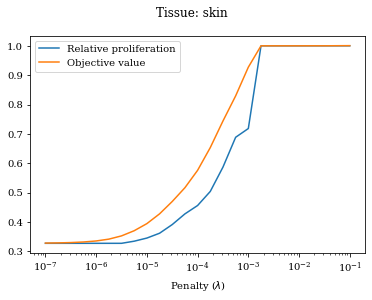

In [9]:
# visualize dependence of objective and achieved proliferation for search results 

fig, ax = plt.subplots()
fig.suptitle('Tissue: ' + TISSUE)

l1, = ax.plot(lambdas, search_prolifs)
l1.set_label("Relative proliferation")

l2, = ax.plot(lambdas, search_objectives)
l2.set_label("Objective value")

ax.set_xscale('log')
ax.set_xlabel("Penalty ($\\lambda$)")
#ax.set_ylabel("Relative proliferation and Objective value")
ax.legend()

plt.show()

In [27]:
# code to evaluate treatment composition
#ticks = ["$10^{-1}$","","","","$10^{-2}$","","","","$10^{-3}$","","","","$10^{-4}$","","","","$10^{-5}$","","","","$10^{-6}$","","","", "$10^{-7}$"]

def plot_bar_chart(ax, df):
    w = 0.45
    ind = np.logspace(min(LAMBDAS), max(LAMBDAS), base=10.0, num=len(LAMBDAS))
    widths = [x * 2.0 * (np.exp(w) - 1) / (np.exp(w) + 1) for x in ind]
    bots = {}

    bots["PD0325901"] = np.zeros(len(ind))
    bots["PLX-4720"] = np.array(df["PD0325901"]) + bots["PD0325901"]
    bots["Selumetinib"] = np.array(df["PLX-4720"]) + bots["PLX-4720"]
    bots["Lapatinib"] = np.array(df["Selumetinib"]) + bots["Selumetinib"]
    bots["Erlotinib"] = np.array(df["Lapatinib"]) + bots["Lapatinib"]
    bots["CHIR-265"] = np.array(df["Erlotinib"]) + bots["Erlotinib"]
    bots["Vandetanib"] = np.array(df["CHIR-265"]) + bots["CHIR-265"]

    p1 = plt.bar(ind, df["PD0325901"], width=widths, edgecolor='white')
    p2 = plt.bar(ind, df["PLX-4720"], width=widths, bottom=bots["PLX-4720"], edgecolor='white')
    p3 = plt.bar(ind, df["Selumetinib"], width=widths, bottom=bots["Selumetinib"], edgecolor='white')
    p4 = plt.bar(ind, df["Lapatinib"], width=widths, bottom=bots["Lapatinib"], edgecolor='white')
    p5 = plt.bar(ind, df["Erlotinib"], width=widths, bottom=bots["Erlotinib"], edgecolor='white')
    p6 = plt.bar(ind, df["CHIR-265"], width=widths, bottom=bots["CHIR-265"], edgecolor='white')
    p7 = plt.bar(ind, df["Vandetanib"], width=widths, bottom=bots["Vandetanib"], edgecolor='white')

    ax.set_ylabel("Total dosage (nM)")
    ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
    
    ax.set_xlabel("Penalty ($\\lambda$)")
    #ax.set_xticks(lambdas)
    #ax.set_xticklabels(ticks[::-1])
    #ax.set_title('Treatment composition: Step ' + str(step))
    ax.set_xscale('log')

    plt.title
    #plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), \
    # ('PD0325901', 'PLX-4720', "Selumetinib", "Lapatinib", "Erlotinib", "CHIR-265", "Vandetanib"))
    plt.legend((p7[0], p6[0], p5[0], p4[0], p3[0], p2[0], p1[0]), \
         ('Vandetanib', 'CHIR-265', "Erlotinib", "Lapatinib", "Selumetinib", "PLX-4720", "PD0325901"))

    
# create new dataframe from combined dictionary
c1 = {}
for k in search_treatments[0]:
    c1[k] = []
    
for i, _ in enumerate(LAMBDAS):
    for k in search_treatments[i]:
        c1[k].append(int(search_treatments[i][k]))
df1 = pd.DataFrame.from_dict(c1)


TypeError: from_bounds() missing 2 required positional arguments: 'width' and 'height'

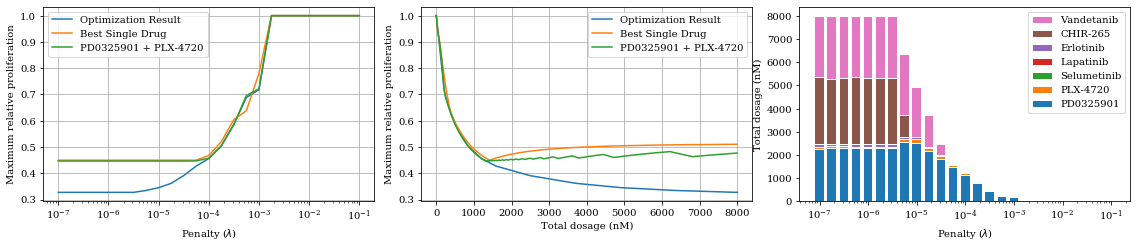

In [45]:
# compare search with baselines with proliferation and objective value

fig, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize=(24 * .65,5 * .65)) # 4x1 format
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,8)) # 2x2 format
# fig.suptitle('Results multi-cell experiment: ' + TISSUE)
# fig.suptitle('Tissue: ' + TISSUE)

l1, = ax1.plot(lambdas, search_prolifs)
l1.set_label("Optimization Result")
l2, = ax1.plot(lambdas, single_prolifs)
l2.set_label("Best Single Drug")
l3, = ax1.plot(lambdas, dual_prolifs)
l3.set_label("PD0325901 + PLX-4720")

# l4, = ax2.plot(lambdas, search_objectives)
# l4.set_label("Optimization Result")
# l5, = ax2.plot(lambdas, single_objectives)
# l5.set_label("Best Single Drug")
# l6, = ax2.plot(lambdas, dual_objectives)
# l6.set_label("PD0325901 + PLX-4720")

l7, = ax3.plot(search_concentration, search_prolifs)
l7.set_label("Optimization Result")
l8, = ax3.plot(single_all_concentrations, single_all_prolifs) 
l8.set_label("Best Single Drug")
l9, = ax3.plot(dual_all_concentrations, dual_all_prolifs)
l9.set_label("PD0325901 + PLX-4720")

#l10, = ax4.plot(lambdas, n_drugs, "o")
#l10.set_label("Search result")
plot_bar_chart(ax4, df1)


ax1.set_xscale('log')
ax1.set_xlabel("Penalty ($\\lambda$)")
ax1.set_ylabel("Maximum relative proliferation")
ax1.legend()
ax1.grid(True)

# ax2.set_xscale('log')
# ax2.set_xlabel("Penalty ($\\lambda$)")
# ax2.set_ylabel("Objective value")
# ax2.legend()
# ax2.grid(True)

ax3.set_xlabel("Total dosage (nM)")
ax3.set_ylabel("Maximum relative proliferation")
ax3.set_xticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax3.legend()
ax3.grid(True)

# old plot: dosage vs. penalty
#ax3.set_xscale('log')
#ax3.set_xlabel("Penalty ($\\lambda$)")
#ax3.set_ylabel("Total dosage (nM)")
#ax3.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
#ax3.legend()
#ax3.grid(True)

#ax4.set_xscale('log')
#ax4.set_xlabel("Penalty ($\\lambda$)")
#ax4.set_ylabel("Number of used drugs")
#ax4.set_yticks([0, 1, 2, 3, 4, 5])
#ax4.grid(True)

# plt.subplots_adjust(left=0.0, right=0.0, top=0.0, bottom=0.0)
plt.tight_layout(pad=0.0, w_pad=0.0)
ax3.set_position((1,0))

plt.savefig("./notebooks/plots/multi_" + TISSUE + ".pdf", bbox_inches='tight')
plt.savefig("./notebooks/plots/multi_" + TISSUE + ".png")
plt.show()

### Investigate the drugs used for the treatment

Format treatments retrieved by search and see if the results are consistent.

In [ ]:
# create new dataframe from combined dictionary

combined = {}
combined["lambda"] = []
for k in search_treatments[0]:
    combined[k] = []

for i, la in enumerate(LAMBDAS):
    combined["lambda"].append(la)
    for k in search_treatments[i]:
        combined[k].append(int(search_treatments[i][k]))

df = pd.DataFrame.from_dict(combined)
df

In [ ]:
# creat heat-map which shows results in percent

# create new dataframe from combined dictionary

combined = {}
combined["lambda"] = []
for k in search_treatments[0]:
    combined[k] = []

for i, la in enumerate(LAMBDAS):
    combined["lambda"].append(la)
    for k in search_treatments[i]:
        combined[k].append(int(search_treatments[i][k]))

df = pd.DataFrame.from_dict(combined)
df

In [ ]:
# Plot heatmap of treatmetn

fig, ax = plt.subplots()

combined = {}
#combined["lambda"] = []
for k in search_treatments[0]:
    combined[k] = []

for i, la in enumerate(LAMBDAS):
 #   combined["lambda"].append(la)
    for k in search_treatments[i]:
        combined[k].append(search_treatments[i][k])

for k in search_treatments[0]:
    combined[k] = reversed(combined[k])
        
df = pd.DataFrame.from_dict(combined)
df_all_transposed = df.transpose()

ticks = ["$10^{-1}$","","","","$10^{-2}$","","","","$10^{-3}$","","","","$10^{-4}$","","","","$10^{-5}$","","","","$10^{-6}$","","","", "$10^{-7}$"]

sns.heatmap(df_all_transposed, xticklabels=ticks, cmap="Reds", ax=ax, cbar_kws={'label': 'Dosage (nM)'})
plt.xlabel("Penalty ($\\lambda$)")
plt.show()

In [ ]:
combined = {}
#combined["lambda"] = []
for k in search_treatments[0]:
    combined[k] = []

for i, la in enumerate(LAMBDAS):
 #   combined["lambda"].append(la)
    for k in search_treatments[i]:
        combined[k].append(search_treatments[i][k])


In [ ]:

width = 0.59       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(LAMBDAS))    # the x locations for the groups
bots = {}

fig, ax = plt.subplots()

bots["PD0325901"] = np.zeros(len(LAMBDAS))
bots["PLX-4720"] = np.array(combined["PD0325901"]) + bots["PD0325901"]
bots["Selumetinib"] = np.array(combined["PLX-4720"]) + bots["PLX-4720"]
bots["Lapatinib"] = np.array(combined["Selumetinib"]) + bots["Selumetinib"]
bots["Erlotinib"] = np.array(combined["Lapatinib"]) + bots["Lapatinib"]
bots["CHIR-265"] = np.array(combined["Erlotinib"]) + bots["Erlotinib"]
bots["Vandetanib"] = np.array(combined["CHIR-265"]) + bots["CHIR-265"]

p1 = plt.bar(ind, combined["PD0325901"], width, edgecolor='white')
p2 = plt.bar(ind, combined["PLX-4720"], width, bottom=bots["PLX-4720"], edgecolor='white')
p3 = plt.bar(ind, combined["Selumetinib"], width, bottom=bots["Selumetinib"], edgecolor='white')
p4 = plt.bar(ind, combined["Lapatinib"], width, bottom=bots["Lapatinib"], edgecolor='white')
p5 = plt.bar(ind, combined["Erlotinib"], width, bottom=bots["Erlotinib"], edgecolor='white')
p6 = plt.bar(ind, combined["CHIR-265"], width, bottom=bots["CHIR-265"], edgecolor='white')
p7 = plt.bar(ind, combined["Vandetanib"], width, bottom=bots["Vandetanib"], edgecolor='white')

ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax.set_xlabel("Penalty ($\\lambda$)")

plt.xticks(ind, ticks[::-1])
plt.ylabel("Total dosage (nM)")
plt.title('Treatment composition')
#plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), \
# ('PD0325901', 'PLX-4720', "Selumetinib", "Lapatinib", "Erlotinib", "CHIR-265", "Vandetanib"))
plt.legend((p7[0], p6[0], p5[0], p4[0], p3[0], p2[0], p1[0]), \
     ('Vandetanib', 'CHIR-265', "Erlotinib", "Lapatinib", "Selumetinib", "PLX-4720", "PD0325901"))

plt.show()

In [ ]:
for k in search_treatments[0]:
    print(k)

In [ ]:
np.array(combined["Vandetanib"])